In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from visualize import PyramidVisualizer, get_dataset, display_image, simple_visualizer, visualize_residuals
from metroem.aligner import Aligner
from corgie import residuals
import cloudvolume as cv
import matplotlib.pylab as plt
import torch
import tqdm
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas 
import scipy
import cachetools

import cc3d
import numpy as np
import fastremap 




def filter_small(mask, th=100):
    cc_labels = cc3d.connected_components(mask)
    segids, counts = np.unique(cc_labels, return_counts=True)
    segids = [ segid for segid, ct in zip(segids, counts) if ct > th ]
    filtered_mask = fastremap.mask_except(cc_labels, segids, in_place=True) != 0

    return filtered_mask

def get_around_defect_region(defects, mip, base_iterations=2):
    defects = filter_small(defects, 16 * (2**(9 - mip)))
    around = scipy.ndimage.binary_dilation(defects, iterations=base_iterations*(2**(9 - mip)))
    right_around = scipy.ndimage.binary_dilation(defects, iterations=1)
    around[right_around == 1] = 0
    return around
    
def get_score(img, mip, defects=None, around_defects=False):
    region = np.ones_like(img)
    thr = 8000 * 2 ** (9 - mip)
    
    if around_defects:
        around_defects = get_around_defect_region(defects, mip=mip)
        region[around_defects == 0] = 0
        thr /= 40
        
    if defects is not None:
        region[defects] = 0
        
    region[img == 0] = 0
    region[img != img] = 0
    
    if (region != 0).sum() < thr:
        return 0, 0
    else:
        return img[region != 0].mean().item(), (region > 0).sum()
    
    
def get_px_count(img):
    zeros = ((img == 0) + (img != img)) > 0
    return (zeros == 0).sum()
    
def get_imgs(z, x_size=1024, y_size=1024, x_start=70000, y_start=0):
    x_size = x_size * 2**img_mip
    y_size = y_size * 2**img_mip
    imgs = {
        name: cvs[name][(x_start)//2**img_mip:(x_start+x_size)//2**img_mip, (y_start)//2**img_mip:(y_start+y_size)//2**img_mip, z:z+1].squeeze() for name in layer_paths
    }
    for k, img in imgs.items():
        if (img != img).sum() > 0: #CPC
            img[img != img] = 0
            img[img != 0] -= img.min()
            img[img != 0] *= -1
            img[img != 0] += 2
            
    return imgs

def get_defects(z, x_size=1024, y_size=1024, x_start=70000, y_start=0, v14=False):
    x_size = x_size * 2**img_mip
    y_size = y_size * 2**img_mip

    imgs = {
        name: defect_cvs[name][(x_start)//2**img_mip:(x_start+x_size)//2**img_mip, (y_start)//2**img_mip:(y_start+y_size)//2**img_mip, z:z+1].squeeze() for name in defect_paths if ('v14' in name) == v14
    }
    
    result = np.zeros_like(list(imgs.values())[0])
    for k, img in imgs.items():
        result[img > 0] = 1
            
    return result

def get_improvement(z, suffix='img', func='absdiff'):
    if scores[z][f'{func}_{suffix}_v14'] == 0 or scores[z][f'{func}_{suffix}'] == 0:
        return 0
    else:
        return 1.0 - scores[z][f'{func}_{suffix}'] / scores[z][f'{func}_{suffix}_v14']
     
def update_df(imgs, defects, df, mip):
    for k, v in imgs.items():
        method = None
        dataset = None
        area = None

            
        if 'v14' in  k:
            dataset = 'Block Matching'
        else:
            dataset = 'This Work'

        if 'emb' in k:
            method = 'Encoding Comparison'
        else:
            method = 'Image Comparison'

        if '16' in k:
            method += '\n(512nm Window)'
        elif '32' in k:
            method += '\n(1024nm Window)'
        else:
            method += '\n(2048nm Window)'
            
        for around_defects in [True, False]:
                    
            if around_defects == False:
                area = 'Whole Image'
            else:
                area = 'Around Defects'
                
            score, px_count = get_score(v, mip, defects[dataset], around_defects)
            score = 2 - score

            new_row = {'Comparison Method': method, 'Alignment Method': dataset, 'CPC Similarity': score, 'Section': z, 'Area': area, 'Pixel Count': px_count}
            df = df.append(new_row, ignore_index=True)
    return df

In [2]:
z_start = 1300
z_end = 2010
df = pandas.DataFrame(columns=['Comparison Method', 'CPC Similarity', 'Section', 'Alignment Method', 'Area', 'Pixel Count'])

defect_paths = {
    'folds_v14': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/fold',
    'cracks_v14': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/crack',
    'folds': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/fold_run_x11',
    'cracks': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/crack_run_x11',   
}

In [ ]:
img_mip = 9

version = 'x21'
layer_paths = {
    'cpc64_img': f'matrix://seamless-paper/prod_x3/cpc64_img_run_x11_a_{version}',
    'cpc64_img_v14': f'matrix://seamless-paper/prod_x3/cpc64_img_v14_run_x11_a_{version}',
    'cpc64_emb': f'matrix://seamless-paper/prod_x3/cpc64_emb_run_x11_a_{version}',
    'cpc64_emb_v14': f'matrix://seamless-paper/prod_x3/cpc64_emb_v14_run_x11_a_{version}',
}

cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in layer_paths.items()
}

defect_cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in defect_paths.items()
}


for z in tqdm.notebook.tqdm(range(z_start, z_end)):
    imgs = get_imgs(z=z)
    defects = {
        'Block Matching': get_defects(z=z, v14=True),
        'This Work': get_defects(z=z, v14=False)
    }
    df = update_df(imgs, defects, df, mip=img_mip)
df.to_pickle(f'cpc64_defects_{z_start}_{z_end}.pkl')

  0%|          | 0/710 [00:00<?, ?it/s]

/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
img_mip = 8

version = 'x21'
layer_paths = {
    'cpc32_img': f'matrix://seamless-paper/prod_x3/cpc32_img_run_x11_a_{version}',
    'cpc32_img_v14': f'matrix://seamless-paper/prod_x3/cpc32_img_v14_run_x11_a_{version}',
    'cpc32_emb': f'matrix://seamless-paper/prod_x3/cpc32_emb_run_x11_a_{version}',
    'cpc32_emb_v14': f'matrix://seamless-paper/prod_x3/cpc32_emb_v14_run_x11_a_{version}',
}

cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in layer_paths.items()
}

defect_cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in defect_paths.items()
}

for z in tqdm.notebook.tqdm(range(z_start, z_end)):
    imgs = get_imgs(z=z)
    defects = {
        'Block Matching': get_defects(z=z, v14=True),
        'This Work': get_defects(z=z, v14=False)
    }
    df = update_df(imgs, defects, df, mip=img_mip)
df.to_pickle(f'cpc32_defects_{z_start}_{z_end}.pkl')

  0%|          | 0/710 [00:00<?, ?it/s]

/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
img_mip = 7

version = 'x21'
layer_paths = {
    'cpc16_img': f'matrix://seamless-paper/prod_x3/cpc16_img_run_x11_a_{version}',
    'cpc16_img_v14': f'matrix://seamless-paper/prod_x3/cpc16_img_v14_run_x11_a_{version}',
    'cpc16_emb': f'matrix://seamless-paper/prod_x3/cpc16_emb_run_x11_a_{version}',
    'cpc16_emb_v14': f'matrix://seamless-paper/prod_x3/cpc16_emb_v14_run_x11_a_{version}',
}

cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in layer_paths.items()
}

defect_cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in defect_paths.items()
}



for z in tqdm.notebook.tqdm(range(z_start, z_end)):
    imgs = get_imgs(z=z)
    defects = {
        'Block Matching': get_defects(z=z, v14=True),
        'This Work': get_defects(z=z, v14=False)
    }
    df = update_df(imgs, defects, df, mip=img_mip)
df.to_pickle(f'cpc16_defects_{z_start}_{z_end}.pkl')

In [19]:
df['CPC Similarity'] = df['CPC Similarity'].astype(float)

In [20]:
df[(df['Area'] != 'Around Defects') * (df['CPC Similarity'] < 1.99) * (df['Section'] < 2000) * (df['Pixel Count'] > 100)]["CPC Similarity"]

1       0.953043
3       0.985289
5       1.443559
7       1.387125
9       0.988214
          ...   
5591    1.031894
5593    1.264471
5595    0.891953
5597    1.559716
5599    1.140629
Name: CPC Similarity, Length: 2781, dtype: float64

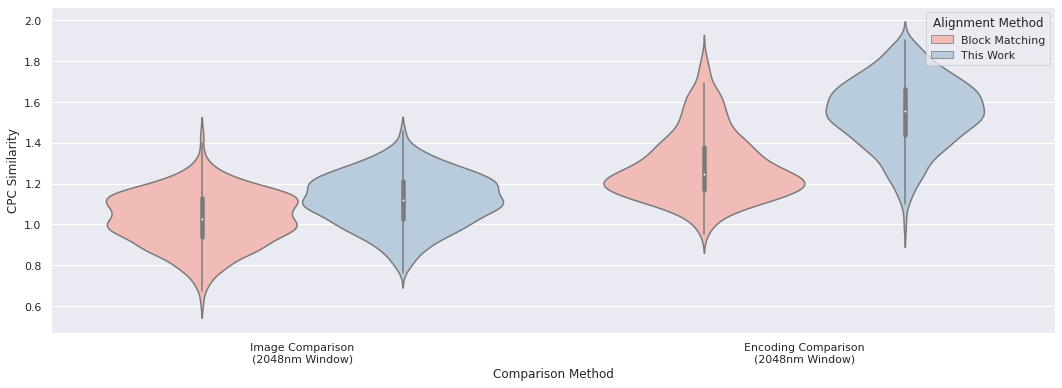

In [22]:
sns.set(style="darkgrid")
plt.figure(figsize=(18, 6))
# Grouped violinplot
ax = sns.violinplot(
    x="Comparison Method", 
    y="CPC Similarity", 
    hue="Alignment Method", 
    data=df[(df['Area'] != 'Around Defects') * (df['CPC Similarity'] < 1.99) * (df['Section'] < 2000) * (df['Pixel Count'] > 100)], 
    palette="Pastel1", 
    hue_order=['Block Matching', 'This Work'],
    order=[
        #'Image Comparison\n(512nm Window)', 
        #'Encoding Comparison\n(512nm Window)',
        #'Image Comparison\n(1024nm Window)', 
        #'Encoding Comparison\n(1024nm Window)', 
        'Image Comparison\n(2048nm Window)', 
        'Encoding Comparison\n(2048nm Window)', 
    ],
)
#ax.set(ylim=(1, 2))
plt.show()

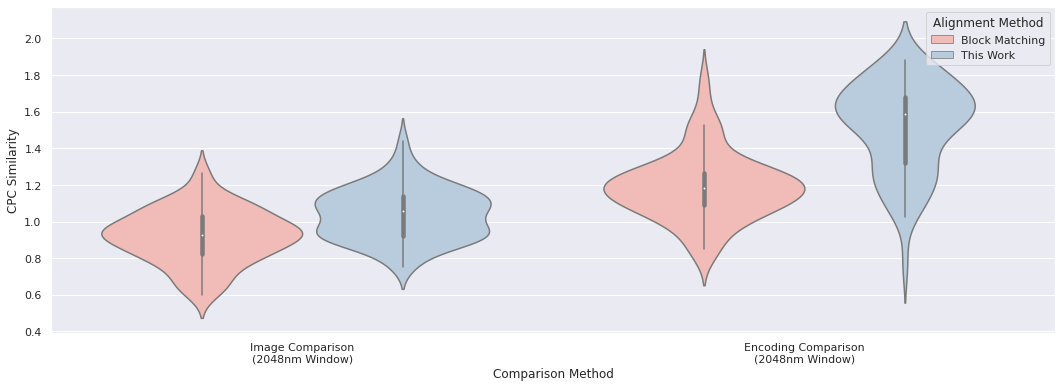

In [23]:
sns.set(style="darkgrid")
plt.figure(figsize=(18, 6))
# Grouped violinplot
ax = sns.violinplot(
    x="Comparison Method", 
    y="CPC Similarity", 
    hue="Alignment Method", 
    data=df[(df['Area'] == 'Around Defects') * (df['CPC Similarity'] < 1.99) * (df['Section'] < 2000) * (df['Pixel Count'] > 100)], 
    palette="Pastel1", 
    hue_order=['Block Matching', 'This Work'],
    order=[
        #'Image Comparison\n(512nm Window)', 
        #'Encoding Comparison\n(512nm Window)',
        #'Image Comparison\n(1024nm Window)', 
        #'Encoding Comparison\n(1024nm Window)', 
        'Image Comparison\n(2048nm Window)', 
        'Encoding Comparison\n(2048nm Window)', 
    ],
)
#ax.set(ylim=(1, 2))
plt.show()

In [70]:
df[df['Area'] == 'Around Defects']['CPC Similarity'].min()

0.6472591161727905

In [76]:
comp_meth = 'Encoding Comparison\n(2048nm Window)'

sections_without_defects = df[(df['Area'] != 'Whole Image') * (df['Pixel Count'] == 0)]['Section']
sections_without_defects = list(np.unique(sections_without_defects.values))

sections_with_defects = df[ df['Section'].isin(sections_without_defects) == 0]['Section']
sections_with_defects = list(np.unique(sections_with_defects.values))
df['Section'].isin(sections_without_defects)
sections_without_defects, sections_with_defects

([1006,
  1007,
  1008,
  1009,
  1011,
  1012,
  1014,
  1015,
  1017,
  1018,
  1020,
  1021,
  1023,
  1024,
  1026,
  1027,
  1029,
  1030,
  1032,
  1033,
  1034,
  1035,
  1036,
  1037,
  1038,
  1039,
  1040,
  1041,
  1042,
  1044,
  1046,
  1047,
  1048,
  1049,
  1050,
  1051,
  1053,
  1054,
  1055,
  1056,
  1058,
  1059,
  1060,
  1062,
  1063,
  1064,
  1065,
  1066,
  1068,
  1069,
  1070,
  1071,
  1072,
  1073,
  1074,
  1075,
  1076,
  1077,
  1078,
  1079,
  1080,
  1081,
  1082,
  1083,
  1084,
  1085,
  1086,
  1087,
  1088,
  1089,
  1090,
  1091,
  1092,
  1093,
  1094,
  1095,
  1096,
  1097,
  1099,
  1101,
  1102,
  1103,
  1111,
  1112,
  1113,
  1114,
  1116,
  1117,
  1118,
  1119,
  1120,
  1122,
  1123,
  1124,
  1125,
  1126,
  1132,
  1133,
  1134,
  1135,
  1136,
  1137,
  1138,
  1139,
  1140,
  1141,
  1142,
  1143,
  1145,
  1148,
  1150,
  1151,
  1157,
  1159,
  1160,
  1163,
  1164,
  1166,
  1167,
  1168,
  1169,
  1170,
  1174,
  1175,
  1176,


In [77]:
df[(df['Section'] == 1008)]

,Comparison Method,CPC Similarity,Section,Alignment Method,Area,Pixel Count
48,Image Comparison\n(2048nm Window),2.000000,1008,This Work,Around Defects,0
49,Image Comparison\n(2048nm Window),1.203316,1008,This Work,Whole Image,12036
50,Image Comparison\n(2048nm Window),2.000000,1008,Block Matching,Around Defects,0
51,Image Comparison\n(2048nm Window),1.133263,1008,Block Matching,Whole Image,11996
52,Encoding Comparison\n(2048nm Window),2.000000,1008,This Work,Around Defects,0
53,Encoding Comparison\n(2048nm Window),1.635877,1008,This Work,Whole Image,12036
54,Encoding Comparison\n(2048nm Window),2.000000,1008,Block Matching,Around Defects,0
55,Encoding Comparison\n(2048nm Window),1.550003,1008,Block Matching,Whole Image,12049


In [20]:
df[whole_with_defects_bm]

,Comparison Method,CPC Similarity,Section,Alignment Method,Area,Pixel Count
7,Encoding Comparison\n(2048nm Window),1.320690,1002,Block Matching,Whole Image,11941
15,Encoding Comparison\n(2048nm Window),1.236992,1003,Block Matching,Whole Image,11463
23,Encoding Comparison\n(2048nm Window),1.253488,1004,Block Matching,Whole Image,11455
31,Encoding Comparison\n(2048nm Window),1.113890,1005,Block Matching,Whole Image,11392
55,Encoding Comparison\n(2048nm Window),1.550003,1008,Block Matching,Whole Image,12049


In [194]:
(df[whole_with_defects_bm]['CPC Similarity'] * df[whole_with_defects_bm]['Pixel Count']).sum()

VolumeCutout(75674.138428)

In [193]:
total_px_count

VolumeCutout(58300)

In [78]:
whole_bm = (
    (df['Area'] == 'Whole Image') * 
    (df['Alignment Method'] == 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) * 
    (df['CPC Similarity'] > 0)
)

whole_with_defects_bm = (df['Section'].isin(sections_with_defects)) * whole_bm

total_px_count = df[whole_with_defects_bm]['Pixel Count'].sum()
total_cpc_diff = (df[whole_with_defects_bm]['CPC Similarity'] * df[whole_with_defects_bm]['Pixel Count']).sum()
total_cpc_diff / total_px_count 

VolumeCutout(1.27440109)

In [79]:
around_bm = (
    (df['Area'] != 'Whole Image') * 
    (df['Alignment Method'] == 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) * 
    (df['CPC Similarity'] > 0)
)

around_with_defects_bm = (df['Section'].isin(sections_with_defects)) * around_bm

total_px_count = df[around_with_defects_bm]['Pixel Count'].sum()
total_cpc_diff = (df[around_with_defects_bm]['CPC Similarity'] * df[around_with_defects_bm]['Pixel Count']).sum()
total_cpc_diff / total_px_count 

VolumeCutout(1.11788935)

In [80]:
whole_this = (
    (df['Area'] == 'Whole Image') * 
    (df['Alignment Method'] != 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) * 
    (df['CPC Similarity'] > 0)
)

around_with_defects_bm = (df['Section'].isin(sections_with_defects)) * whole_this

total_px_count = df[around_with_defects_bm]['Pixel Count'].sum()
print (total_px_count)
total_cpc_diff = (df[around_with_defects_bm]['CPC Similarity'] * df[around_with_defects_bm]['Pixel Count']).sum()
total_cpc_diff / total_px_count 

720763


VolumeCutout(1.46079679)

In [81]:
around_this = (
    (df['Area'] != 'Whole Image') * 
    (df['Alignment Method'] != 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) * 
    (df['CPC Similarity'] > 0)
)

around_with_defects_bm = (df['Section'].isin(sections_with_defects)) * around_this

total_px_count = df[around_with_defects_bm]['Pixel Count'].sum()
print (total_px_count)
total_cpc_diff = (df[around_with_defects_bm]['CPC Similarity'] * df[around_with_defects_bm]['Pixel Count']).sum()
total_cpc_diff / total_px_count 

37916


VolumeCutout(1.37584072)

In [39]:
v1 = df[(
    (df['Area'] == 'Whole Image') * 
    (df['Alignment Method'] == 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) *
    (df['Comparison Method'] == comp_meth) *
    (df['Section'].isin(sections_with_defects))
)]['CPC Similarity'].mean()
v1

1.2312652319669724

In [212]:
v2 = df[(
    (df['Area'] != 'Whole Image') * 
    (df['Alignment Method'] == 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) *
    (df['Comparison Method'] == comp_meth) *
    (df['Section'].isin(sections_with_defects))
)]['CPC Similarity'].mean()
v2

1.1915411800146103

In [213]:
v2/v1

0.9677372097245839

In [142]:
v1 = df[(
    (df['Area'] == 'Whole Image') * 
    (df['Alignment Method'] != 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) *
    (df['Comparison Method'] == comp_meth) *
    (df['Section'].isin(sections_with_defects))
)]['CPC Similarity'].mean()
v1

1.3518868148326875

In [143]:
v2 = df[(
    (df['Area'] != 'Whole Image') * 
    (df['Alignment Method'] != 'Block Matching') * 
    (df['Comparison Method'] == comp_meth) *
    (df['Comparison Method'] == comp_meth) *
    (df['Section'].isin(sections_with_defects))
)]['CPC Similarity'].mean()
v2

1.297178077697754

In [144]:
v2/v1

0.959531569851353

In [10]:
img_mip = 7

version = 'x21'
layer_paths = {
    'cpc64_img': f'matrix://seamless-paper/prod_x3/cpc64_img_run_x11_a_{version}',
    'cpc64_img_v14': f'matrix://seamless-paper/prod_x3/cpc64_img_v14_run_x11_a_{version}',
    'cpc64_emb': f'matrix://seamless-paper/prod_x3/cpc64_emb_run_x11_a_{version}',
    'cpc64_emb_v14': f'matrix://seamless-paper/prod_x3/cpc64_emb_v14_run_x11_a_{version}',
    'folds': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/fold',
    'cracks': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/crack',
}

cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in layer_paths.items()
}
imgs = get_imgs(z=1003)

In [38]:
img_mip = 7

defect_cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in defect_paths.items()
}

defects = get_defects(z=1004, v14=False)
defects_v14 = get_defects(z=1004, v14=True)
print((defects != 0).sum())
simple_visualizer().visualize([defects, filter_small(defects, 8 * (2**(9 - img_mip))), defects_v14, get_around_defect_region(defects, mip=img_mip)])

210


/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3), value=0), IntText(value=1, des…

In [11]:
img_mip = 7
version = 'x21'
layer_paths = {
    'folds_v14': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/fold',
    #'cracks_v14': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/crack',
    'folds': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/fold_run_x11',
    #'cracks': f'matrix://seamless-paper/prod_x3/binarized_masks/mask/crack_run_x11',
    #'cpc64_emb': f'matrix://seamless-paper/prod_x3/cpc64_emb_run_x11_a_{version}',
    #'cpc64_emb_v14': f'matrix://seamless-paper/prod_x3/cpc64_emb_v14_run_x11_a_{version}',
}

cvs = {
    name: cv.CloudVolume(path, mip=img_mip, parallel=True, progress=False, bounded=False) for name, path in layer_paths.items()
}

imgs = get_imgs(z=1003)
simple_visualizer().visualize(list(imgs.values()))

interactive(children=(ToggleButtons(description='Image:', options=(0, 1), value=0), IntText(value=1, descripti…

In [54]:
simple_visualizer().visualize([(imgs['absdiff_norm_v14'] == 0).astype(np.float)] + list(imgs.values()))

/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


interactive(children=(ToggleButtons(description='Image:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8), value=0), IntTe…

  0%|          | 0/1000 [00:00<?, ?it/s]

1000 0
1001 0
1002 -0.019406259059906006
1003 -0.0383530855178833
1004 -0.02102375030517578
1005 -0.01585167646408081
1006 -0.016450166702270508
1007 -0.003996670246124268
1008 0.004606008529663086
1009 -0.0006996393203735352
1010 -0.019391179084777832
1011 -0.019864022731781006
1012 -0.009700000286102295
1013 -0.01079559326171875
1014 -0.004783689975738525
1015 -0.011059463024139404
1016 -0.0051541924476623535
1017 -0.009232163429260254
1018 -0.016878068447113037
1019 -0.03520089387893677
1020 -0.016086578369140625
1021 -0.012639939785003662
1022 -0.01449495553970337
1023 -0.016217529773712158
1024 -0.010630190372467041
1025 -0.006922304630279541
1026 -0.004856586456298828
1027 -0.011847436428070068
1028 -0.009919464588165283
1029 -0.006367087364196777
1030 -0.019355714321136475
1031 -0.01330256462097168
1032 -0.012924671173095703
1033 -0.03311944007873535
1034 -0.004425406455993652
1035 -0.01828598976135254
1036 -0.013882100582122803
1037 0.0069653987884521484
1038 -0.000381290912628

In [358]:
#emb_diff = {z: get_improvement(z, 'emb') for z in range(z_start, z_end)}
#img_diff = {z: get_improvement(z, 'img') for z in range(z_start, z_end)}

emb_cpc = {z: get_improvement(z, 'emb', 'cpc64') for z in range(z_start, z_end)}
img_cpc = {z: get_improvement(z, 'img', 'cpc64') for z in range(z_start, z_end)}

yo
yo
yo
yo
yo
yo
yo
yo


In [227]:
np.array(y_emb_cpc).mean()

0.3654867448705308

In [228]:
for k, v in emb_diff.items():
    if v < 0:
        print (k, v)

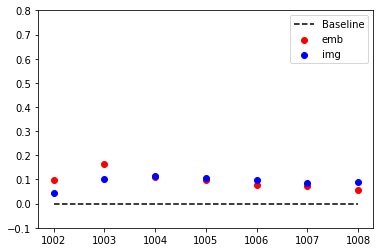

In [238]:
lists = sorted(it for it in emb_diff.items() if it[-1] != 0) # sorted by key, return a list of tuples
x_diff_x0, y_diff_x0 = zip(*lists)

lists = sorted(it for it in img_diff.items() if it[-1] != 0) # sorted by key, return a list of tuples

x_diff_x1, y_diff_x1 = zip(*lists)

y_baseline = [0.0 for _ in x_diff_x0]

plt.scatter(x_diff_x0, y_diff_x0, color='red', label='emb')
plt.scatter(x_diff_x1, y_diff_x1, color='blue', label='img')

plt.plot(x_diff_x0, y_baseline, color='black', label='Baseline', linestyle='dashed')

#plt.yscale('symlog', basey=10, basex=10, linthreshy=0.2)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.3f')) #Here!
plt.ylim(ymax=0.8, ymin=-0.1)

plt.legend()
plt.show()

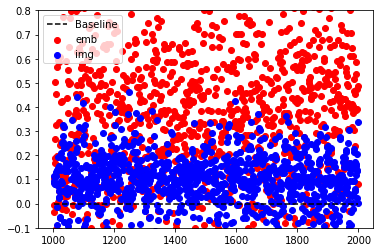

In [359]:
lists = sorted(it for it in emb_cpc.items() if it[-1] != 0) # sorted by key, return a list of tuples
x_diff_x0, y_diff_x0 = zip(*lists)

lists = sorted(it for it in img_cpc.items() if it[-1] != 0) # sorted by key, return a list of tuples

x_diff_x1, y_diff_x1 = zip(*lists)

y_baseline = [0.0 for _ in x_diff_x0]

plt.scatter(x_diff_x0, y_diff_x0, color='red', label='emb')
plt.scatter(x_diff_x1, y_diff_x1, color='blue', label='img')

plt.plot(x_diff_x0, y_baseline, color='black', label='Baseline', linestyle='dashed')

#plt.yscale('symlog', basey=10, basex=10, linthreshy=0.2)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.3f')) #Here!
plt.ylim(ymax=0.8, ymin=-0.1)

plt.legend()
plt.show()

In [40]:
for i in range(1300, 1350):
    #print (i)
    if i in emb_diff and emb_diff[i] < 0:
        print (i, emb_diff[i])

1310 -0.014723360538482666
1319 -0.010295689105987549
1320 -0.006379902362823486
1327 -0.024768054485321045
1328 -0.05214351415634155
1329 -0.026741862297058105
1330 -0.01818406581878662
1334 -0.010693609714508057
1339 -0.002771914005279541


/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'basex'. In the future this will raise TypeError
  if sys.path[0] == '':
/usr/people/popovych/env/corgie_merge/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'basex'. In the future this will raise TypeError
  del sys.path[0]


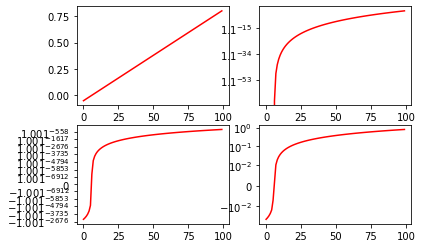

In [173]:
import matplotlib.pyplot as plt
from matplotlib import ticker

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(False) 

fig, axs = plt.subplots(2, 2)



axs[0, 1].set_yscale('log', basey=1.1)
axs[1, 0].set_yscale('symlog', basex=1.001, basey=1.001, linthreshy=0.001)
axs[1, 1].set_yscale('symlog', basey=10, basex=10, linthreshy=0.01)

axs[0, 0].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')
axs[0, 1].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')
axs[1, 0].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')
axs[1, 1].plot(np.linspace(-0.05, 0.8, 100), color='red', label='Normalized')

plt.show()

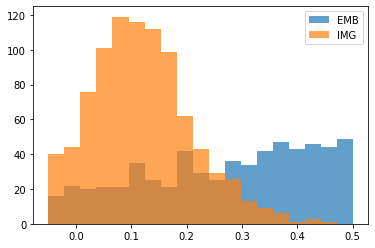

In [360]:
import random
import numpy
from matplotlib import pyplot


bins = numpy.linspace(-0.05, 0.5, 20)
#bins = 30
pyplot.hist(y_diff_x0, bins=bins, alpha=0.7, label='EMB')
pyplot.hist(y_diff_x1, bins=bins, alpha=0.7, label='IMG')
#pyplot.hist(y_emb, bins, alpha=0.7, label='Embedding')
pyplot.legend(loc='upper right')
pyplot.show()

# import random
import numpy
from matplotlib import pyplot


bins = numpy.linspace(-0.05, 0.5, 40)
#bins = 30
pyplot.hist(y_emb, bins=bins, alpha=0.5, label='MSE')
pyplot.hist(y_emb_cpc, bins=bins, alpha=0.5, label='CPC')
#pyplot.hist(y_norm_cpc, bins=bins, alpha=0.7, label='NORM CPC')
#pyplot.hist(y_emb, bins, alpha=0.7, label='Embedding')
pyplot.legend(loc='upper right')
pyplot.show()

In [31]:
np.array(y_emb).mean()

0.06880007225502904

In [34]:
np.percentile(np.array(y_emb), 50)

0.03214883804321289

In [29]:
sum([y > 0.05 for y in y_emb])

VolumeCutout(301)

In [ ]:
lists = sorted(it for it in emb_cpc_x0.items() if it[-1] != 0) # sorted by key, return a list of tuples
x_cpc_x0, y_cpc_x0 = zip(*lists)

lists = sorted(it for it in emb_cpc_x1.items() if it[-1] != 0) # sorted by key, return a list of tuples

x_cpc_x1, y_cpc_x1 = zip(*lists)

y_baseline = [0.0 for _ in x_cpc_x0]

plt.scatter(x_cpc_x0, y_cpc_x0, color='red', label='x0')
plt.scatter(x_cpc_x1, y_cpc_x1, color='blue', label='x1')
plt.plot(x_cpc_x0, y_baseline, color='black', label='Baseline', linestyle='dashed')

#plt.yscale('symlog', basey=10, basex=10, linthreshy=0.2)
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%0.3f')) #Here!
#plt.ylim(ymax=1, ymin=-0.1)

plt.legend()
plt.show()

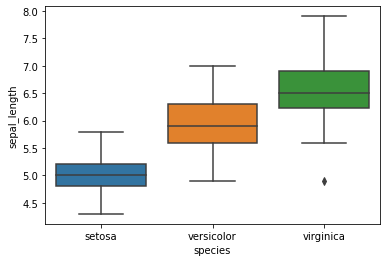

In [365]:
import seaborn as sns
df = sns.load_dataset('iris')

sns.boxplot( x=df["species"], y=df["sepal_length"] )

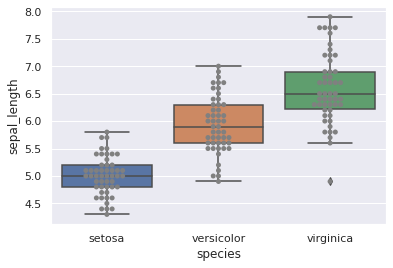

In [370]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
df = sns.load_dataset('iris')

# Usual boxplot
ax = sns.boxplot(x='species', y='sepal_length', data=df)
 
# Add jitter with the swarmplot function
ax = sns.swarmplot(x='species', y='sepal_length', data=df, color="grey")
plt.show()

In [368]:
df["sepal_length"]

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal_length, Length: 150, dtype: float64

In [369]:
df["species"] 

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [391]:
type(df)

pandas.core.frame.DataFrame

In [392]:
import pandas

In [465]:
df['CPC Similarity'].min()

0.6137425899505615

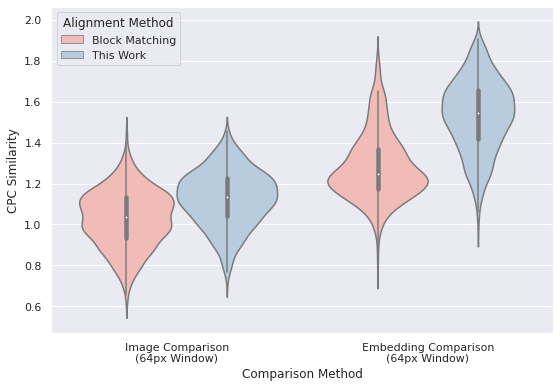